In [1]:
# === colab configuration ===
# p.s. when training on colab, weights are saved on Drive (directory DSCAS/weights).
# p.p.s. skip this cell if running demo file locally!

! pip install torch-summary
! pip install ray
from google.colab import drive
import sys

# setting paths
repository_path = '/content/deep-seasonal-color-analysis-system/'
dataset_path = repository_path + 'headsegmentation_dataset_ccncsa/'
dataset_path_drive = '/content/drive/MyDrive/DSCAS/headsegmentation_dataset_ccncsa/'
weights_path = repository_path + 'models/weights/'
weights_path_drive = '/content/drive/MyDrive/DSCAS/weights/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/mrcmich/deep-seasonal-color-analysis-system.git
! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'fastscnn_hyperparameters_tuning__refactoring'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
Cloning into 'deep-seasonal-color-analysis-system'...
remote: Enumerating objects: 506, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 506 (delta 108), reused 144 (delta 94), pack-reused 312
Receiving objects: 100% (506/506), 81.86 MiB | 39.90 MiB/s, done.
Resolving deltas: 100% (254/254), done.
/content/deep-seasonal-color-analysis-system
Already on 'main'
Your branch is up to date with 'origin/main'.
From https://github.com/mrcmich/deep-seasonal-color-analysis-system
 * branch            main       -> FETCH_HEAD
Already up to date.


In [4]:
import torch
from torch import nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.local.CGNet.model import CGNet
from metrics_and_losses import metrics
from utils import segmentation_labels, utils
import matplotlib.pyplot as plt
from palette_classification import color_processing
import torchsummary
from models import config

try:
  executing_on_colab
except NameError:
  executing_on_colab = False
  weights_path = config.WEIGHTS_PATH
  dataset_path = config.DATASET_PATH

In [5]:
# defining transforms
tH, tW = 256, 256
image_transform = T.Compose([T.Resize((tH, tW)), T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])
target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, file_name=config.DATASET_INDEX_NAME)
X_train, X_test, Y_train, Y_test = train_test_split(
    img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
train_dataset = dataset.MyDataset(X_train, Y_train, image_transform, target_transform)
test_dataset = dataset.MyDataset(X_test, Y_test, image_transform, target_transform)

# training and test hyperparameters
batch_size = 32
device = 'cuda' if executing_on_colab is True else 'cpu'

In [5]:
# training hyperparameters
n_epochs = 50

# model, loss, score function
model_name = 'cgnet_ccncsa'
model = CGNet.Context_Guided_Network(classes=n_classes)
loss_fn = nn.CrossEntropyLoss()
score_fn = metrics.batch_mIoU

# optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_summary = torchsummary.summary(model, input_data=(batch_size, 3, tH, tW), batch_dim=None, verbose=0)
print(model_summary)

Layer (type:depth-idx)                        Output Shape              Param #
├─ConvBNPReLU: 1-1                            [32, 32, 128, 128]        --
|    └─Conv2d: 2-1                            [32, 32, 128, 128]        864
|    └─BatchNorm2d: 2-2                       [32, 32, 128, 128]        64
|    └─PReLU: 2-3                             [32, 32, 128, 128]        32
├─ConvBNPReLU: 1-2                            [32, 32, 128, 128]        --
|    └─Conv2d: 2-4                            [32, 32, 128, 128]        9,216
|    └─BatchNorm2d: 2-5                       [32, 32, 128, 128]        64
|    └─PReLU: 2-6                             [32, 32, 128, 128]        32
├─ConvBNPReLU: 1-3                            [32, 32, 128, 128]        --
|    └─Conv2d: 2-7                            [32, 32, 128, 128]        9,216
|    └─BatchNorm2d: 2-8                       [32, 32, 128, 128]        64
|    └─PReLU: 2-9                             [32, 32, 128, 128]        32
├─InputInject

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [6]:
# training
results = training_and_testing.train_model(
    device, model, train_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
    lr_scheduler=None, evaluate=True, verbose=True)

Device: cuda.
--- Epoch 1/50 ---
average_train_loss: 0.43818296326531303, average_train_score: 0.43376851081848145
average_val_loss: 0.5859759544569348, average_val_score: 0.45546820759773254
--- Epoch 2/50 ---
average_train_loss: 0.2033958288594189, average_train_score: 0.5740530490875244
average_val_loss: 0.2079418216432844, average_val_score: 0.5601341724395752
--- Epoch 3/50 ---
average_train_loss: 0.14920257883109259, average_train_score: 0.6269931793212891
average_val_loss: 0.1464706484287504, average_val_score: 0.6252785921096802
--- Epoch 4/50 ---
average_train_loss: 0.1306145735658132, average_train_score: 0.6484449505805969
average_val_loss: 0.23262179678394682, average_val_score: 0.5889959931373596
--- Epoch 5/50 ---
average_train_loss: 0.1273107620704378, average_train_score: 0.6525813937187195
average_val_loss: 0.14229213943084082, average_val_score: 0.6412655115127563
--- Epoch 6/50 ---
average_train_loss: 0.11325452815306153, average_train_score: 0.6680285930633545
avera

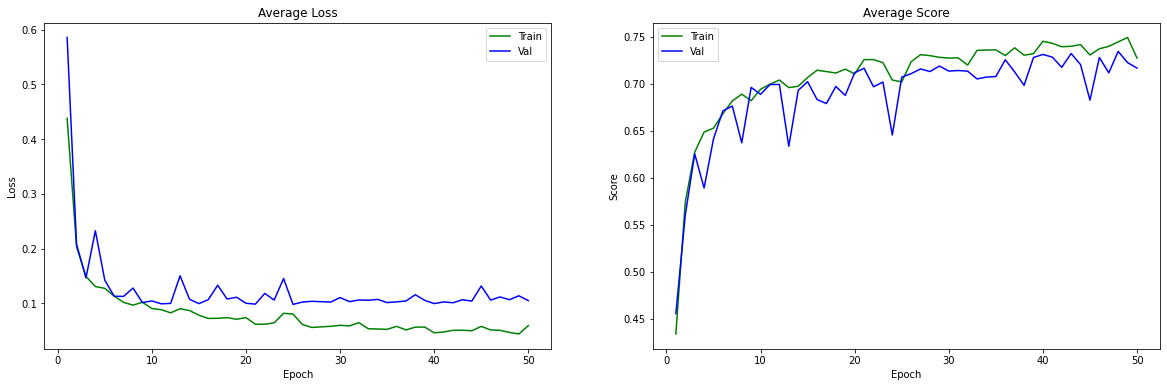

In [7]:
# plotting training results
training_and_testing.plot_training_results(results, plotsize=(20, 6))

In [ ]:
# resetting model, optimizer, learning rate scheduler
final_model = CGNet.Context_Guided_Network(classes=n_classes)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate)

# re-training model on entire training set and saving its weights
final_n_epochs = n_epochs // 2
training_and_testing.train_model(
    device, final_model, train_dataset, batch_size, final_n_epochs, score_fn, loss_fn, final_optimizer, verbose=True)
    
# saving final model's weights
torch.save(final_model.state_dict(), weights_path + model_name + '.pth')
if executing_on_colab is True:
  torch.save(final_model.state_dict(), weights_path_drive + model_name + '.pth')

Device: cuda.
--- Epoch 1/25 ---
average_train_loss: 0.410920042499503, average_train_score: 0.4534393548965454
--- Epoch 2/25 ---
average_train_loss: 0.18492434433600516, average_train_score: 0.5905128717422485
--- Epoch 3/25 ---
average_train_loss: 0.14295769978955064, average_train_score: 0.6329661011695862
--- Epoch 4/25 ---
average_train_loss: 0.12729024183519239, average_train_score: 0.6513964533805847
--- Epoch 5/25 ---
average_train_loss: 0.11086253323941773, average_train_score: 0.6706602573394775
--- Epoch 6/25 ---
average_train_loss: 0.10648563750467058, average_train_score: 0.67515629529953
--- Epoch 7/25 ---
average_train_loss: 0.10409734651590663, average_train_score: 0.6788666844367981
--- Epoch 8/25 ---
average_train_loss: 0.09929930517048582, average_train_score: 0.6826308965682983
--- Epoch 9/25 ---
average_train_loss: 0.0897015392166939, average_train_score: 0.6950570940971375
--- Epoch 10/25 ---
average_train_loss: 0.0854749280878187, average_train_score: 0.69853281

In [ ]:
# loading pretrained final model
try:
    final_model
except:
    final_model = CGNet.Context_Guided_Network(classes=n_classes)
    final_model.load_state_dict(torch.load(weights_path + model_name + '.pth'))

# testing model on test dataset
test_score_fn = metrics.batch_IoU
batch_IoU = training_and_testing.test_model(device, final_model, test_dataset, batch_size, test_score_fn)

# printing test report
training_and_testing.print_IoU_report(batch_IoU)

Device: cuda.

Inference completed in around 52 seconds.
batch_IoU_background: 0.9561692476272583
batch_IoU_lips: 0.5542100071907043
batch_IoU_eyes: 0.4434087872505188
batch_IoU_nose: 0.7245395183563232
batch_IoU_skin: 0.870031476020813
batch_IoU_hair: 0.8192286491394043
batch_IoU_eyebrows: 0.41084420680999756
batch_IoU_ears: 0.6688153147697449
batch_IoU_teeth: 0.6525847315788269
batch_IoU_beard: 0.8450974225997925
batch_IoU_sunglasses: 0.9007096290588379
batch_mIoU=0.7132399082183838


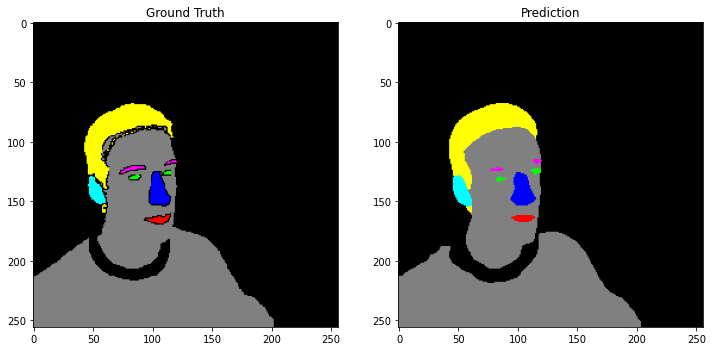

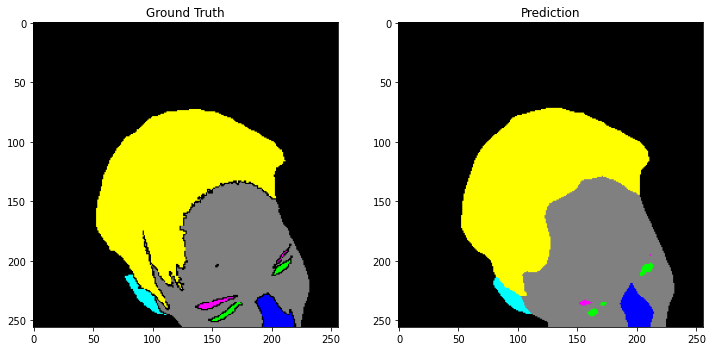

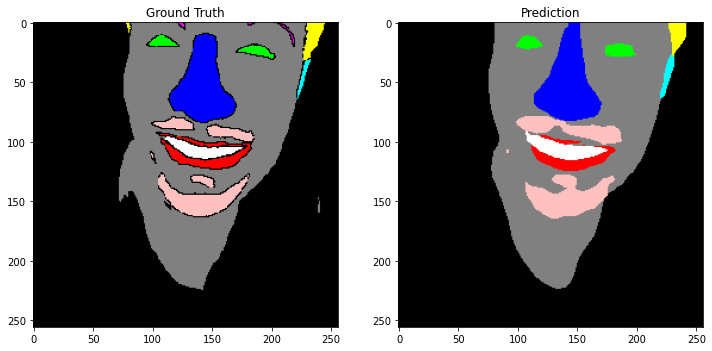

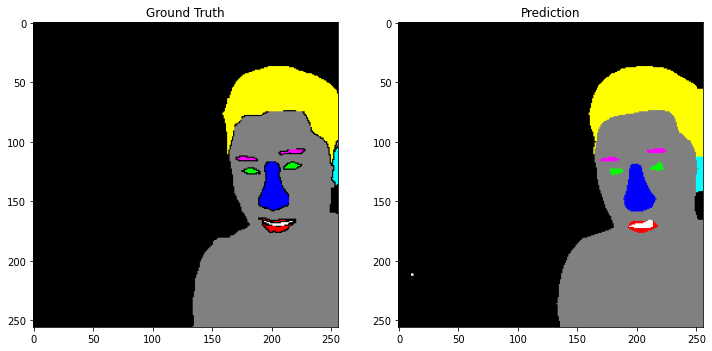

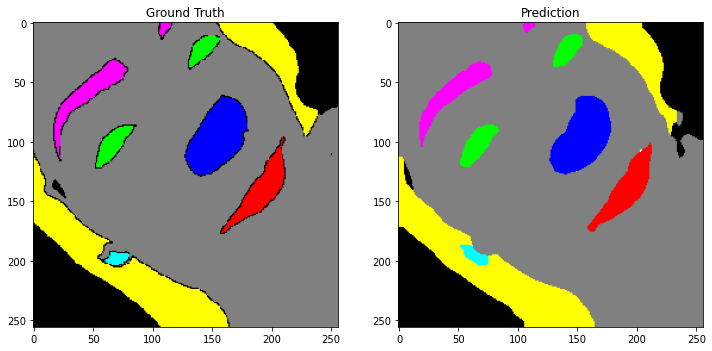

In [ ]:
# plotting some examples from test dataset
utils.plot_random_examples(device, final_model, test_dataset, n_examples=5)